## Lets code up a rock-paper-scissors game and look at different variants

In [51]:
import numpy as np

## We are going to do a perturbed version of rock paper scissors so that the equilibrium is not exactly [1/3, 1/3, 1/3]

This one has solution [0.4, 0.4, 0.2] and is called "rock-paper-scissors-lizard-Spock" and is from the TV show "The Big Bang Theory"

To be clear, it is not called that but co-pilot thinks it is and that is so funny to me.

In [52]:
A = np.array([[0, -1, 2], 
              [1, 0, -2], 
              [-2, 2, 0]])


In [53]:
def compute_outcome(x_strategy, y_strategy, player=0):
    """The strategy vector represents rock, paper, scissors"""
    value = x_strategy.T @ A @ y_strategy
    if player == 0:
        return value
    else:
        return -value
    
def compute_reward_vector(x_strategy, y_strategy, player=0):
    """Computes the reward vector for a given strategy"""
    if player == 0:
        return A @ y_strategy
    else:
        return - (x_strategy.T @ A).T

## Plotting code

In [92]:
import matplotlib.pyplot as plt
import mpltern

def plot_results(x_policy_arr, y_policy_arr, time_avg=True):
    nash = np.array([0.4, 0.4, 0.2])
    # okay now at each time-step we want to compute the average strategy up to that time
    # i.e. we want to form the cumsum on each axis and then divide by the row index
    if time_avg:
        x_policy_avg = np.cumsum(x_policy_arr, axis=0) / np.arange(1, x_policy_arr.shape[0] + 1)[:, None]
    # y_policy_avg = np.cumsum(y_policy_arr, axis=0) / np.arange(1, y_policy_arr.shape[0] + 1)[:, None]
        plt.figure()
        plt.style.use("ggplot")
        ax = plt.subplot(projection="ternary")
        ax.set_tlabel("Rock")
        ax.set_llabel("Paper")
        ax.set_rlabel("Scissors")
        ax.set_title("Time averaged strategies")
        ax.scatter(x_policy_arr[0, 0], x_policy_arr[0, 1], x_policy_arr[0, 2], color="red", s=40)
        ax.scatter(nash[0], nash[1], nash[2], color="green", s=40)
        ax.plot(x_policy_avg[:, 0], x_policy_avg[:, 1], x_policy_avg[:, 2], color="blue")

        # now lets plot the distance to nash as a function of iterate where
        # Nash is [0.4, 0.4, 0.2]
        x_policy_dist = np.linalg.norm(x_policy_avg - nash, axis=1)
        plt.figure()
        plt.plot(x_policy_dist)
        plt.xlabel("Iteration")
        plt.ylabel("Distance to Nash")
    plt.figure()
    plt.style.use("ggplot")
    ax = plt.subplot(projection="ternary")
    ax.set_tlabel("Rock")
    ax.set_llabel("Paper")
    ax.set_rlabel("Scissors")
    ax.set_title("Actual strategies")
    ax.scatter(x_policy_arr[0, 0], x_policy_arr[0, 1], x_policy_arr[0, 2], color="red", s=40)
    ax.scatter(nash[0], nash[1], nash[2], color="green", s=40)
    ax.plot(x_policy_arr[:, 0], x_policy_arr[:, 1], x_policy_arr[:, 2], color="blue")

## Lets start with best response i.e. each agent runs gradient descent / REINFORCE independently

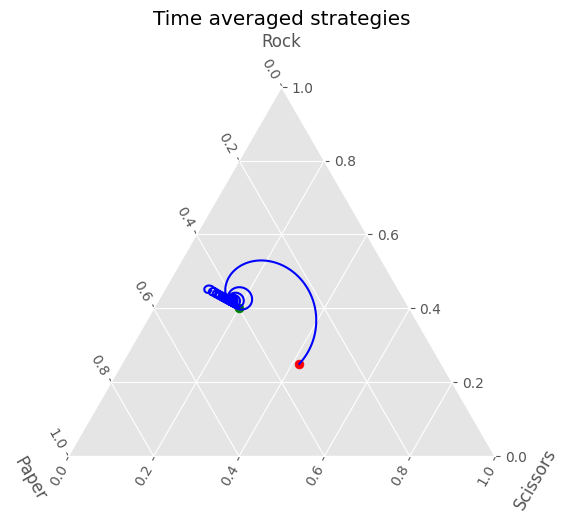

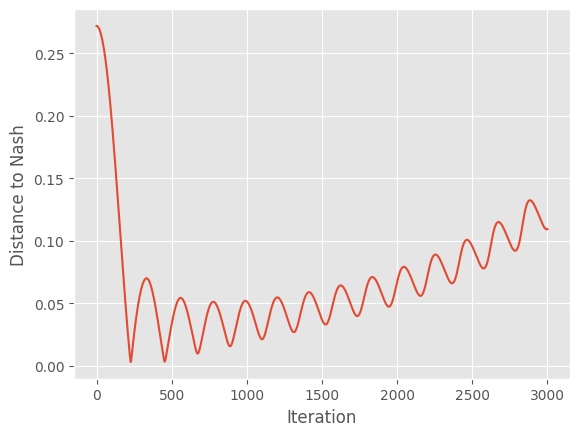

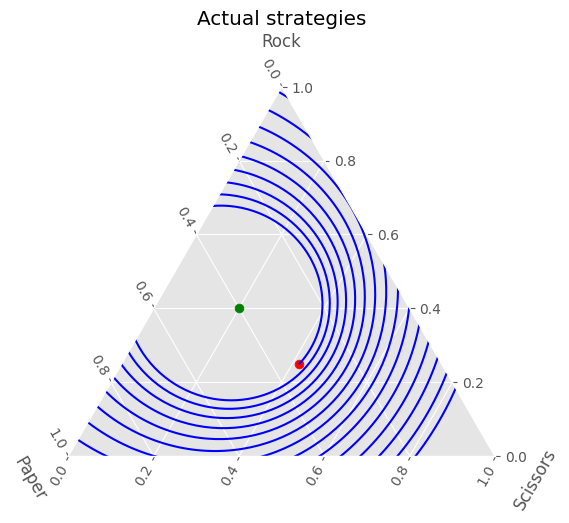

In [97]:

class BestResponse():
    def __init__(self, initial_guess):
        self.strategy = initial_guess
        self.learning_rate = 0.01

    def update(self, reward_vector):
        """Update the prior weights using the multiplicative weights update algorithm"""
        self.strategy += self.learning_rate * reward_vector
        self.strategy = self.compute_policy()

    def compute_policy(self):
        """We need to normalize the strategy to make it a probability distribution"""
        return self.strategy / np.sum(self.strategy)


x_policy = BestResponse(np.array([0.3, 0.4, 0.5]))
y_policy = BestResponse(np.array([0.3, 0.4, 0.5]))
num_iters = 3000
x_policy_arr = np.zeros((num_iters + 1, 3))
y_policy_arr = np.zeros((num_iters + 1, 3))
x_policy_arr[0] = x_policy.compute_policy()
y_policy_arr[0] = y_policy.compute_policy()

for i in range(1, num_iters + 1):
    x_reward = compute_reward_vector(x_policy.compute_policy(), y_policy.compute_policy(), 0)
    y_reward = compute_reward_vector(x_policy.compute_policy(), y_policy.compute_policy(), 1)
    x_policy.update(x_reward)
    y_policy.update(y_reward)
    x_policy_arr[i] = x_policy.compute_policy()
    y_policy_arr[i] = y_policy.compute_policy()

plot_results(x_policy_arr, y_policy_arr, time_avg=True)


## Now lets try Multiplicative Weights / Regularized Follow the Leader

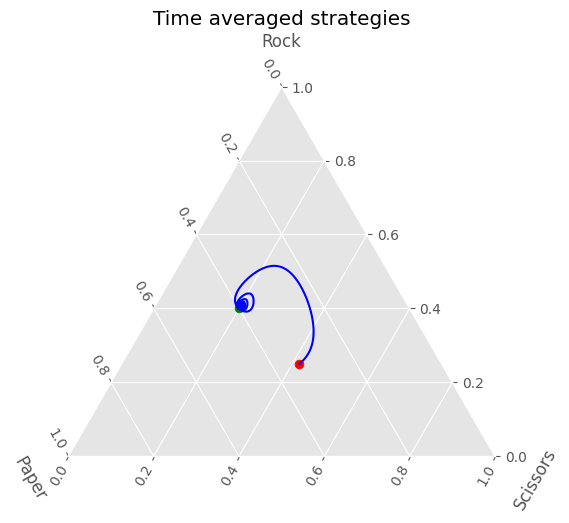

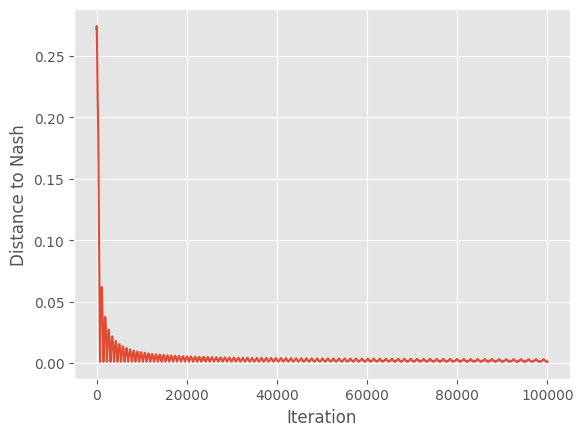

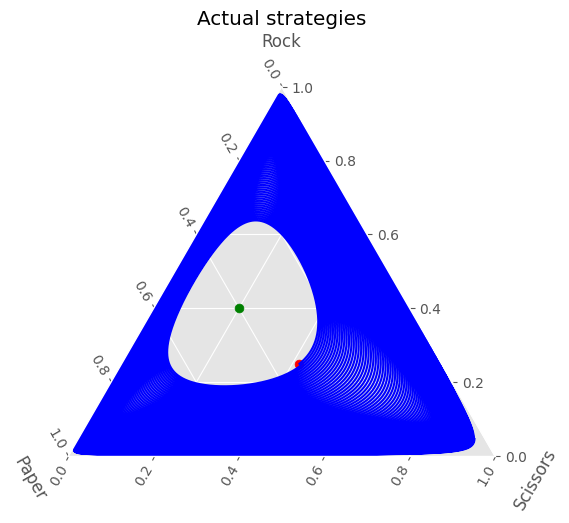

In [101]:
class BestResponse():
    def __init__(self, initial_guess):
        self.weights = initial_guess
        self.eta = 0.01

    def update(self, reward_vector):
        """Update the prior weights using the multiplicative weights update algorithm"""
        self.weights *= np.exp(self.eta * reward_vector)

    def compute_policy(self):
        """We need to normalize the strategy to make it a probability distribution"""
        return self.weights / np.sum(self.weights)


x_policy = BestResponse(np.array([0.3, 0.4, 0.5]))
y_policy = BestResponse(np.array([0.3, 0.4, 0.5]))
num_iters = 100000
x_policy_arr = np.zeros((num_iters + 1, 3))
y_policy_arr = np.zeros((num_iters + 1, 3))
x_policy_arr[0] = x_policy.compute_policy()
y_policy_arr[0] = y_policy.compute_policy()

for i in range(1, num_iters + 1):
    x_reward = compute_reward_vector(x_policy.compute_policy(), y_policy.compute_policy(), 0)
    y_reward = compute_reward_vector(x_policy.compute_policy(), y_policy.compute_policy(), 1)
    x_policy.update(x_reward)
    y_policy.update(y_reward)
    x_policy_arr[i] = x_policy.compute_policy()
    y_policy_arr[i] = y_policy.compute_policy()

plot_results(x_policy_arr, y_policy_arr, time_avg=True)


# def multiplicative_weights_update(prior_policy, reward_vector, eta):
#     """Update the prior weights using the multiplicative weights update algorithm"""
#     return prior_policy * np.exp(eta * reward_vector)

# def compute_policy(weights):
#     """Compute the policy from the weights"""
#     return weights / np.sum(weights)

# def mw_policy_update(prior_policy, reward_vector):
#     """Update the policy using the multiplicative weights update algorithm"""
#     eta = 0.1
#     update = multiplicative_weights_update(prior_policy, reward_vector, eta)
#     return compute_policy(update)

# x_policy_arr, y_policy_arr = run_simulation(np.array([1, 0.5, 0.5]), np.array([0.5, 0.5, 1]), mw_policy_update, num_iters=100)



## Lets try out some of the other no-regret learning algos and compare!

Note, this one breaks some abstraction barriers we were using earlier. There's not an easily invertible mapping between our policy and the regret tracker

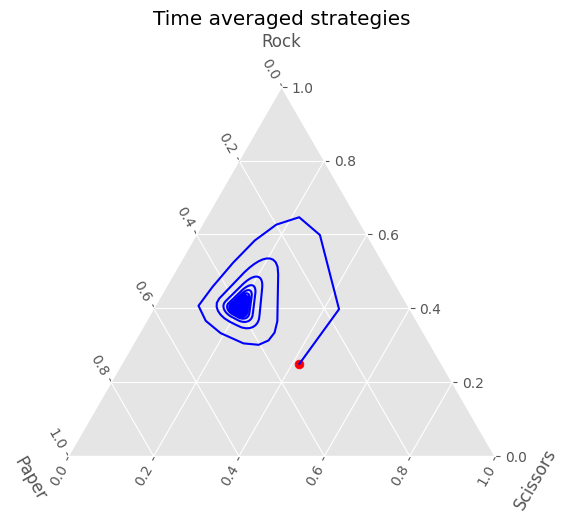

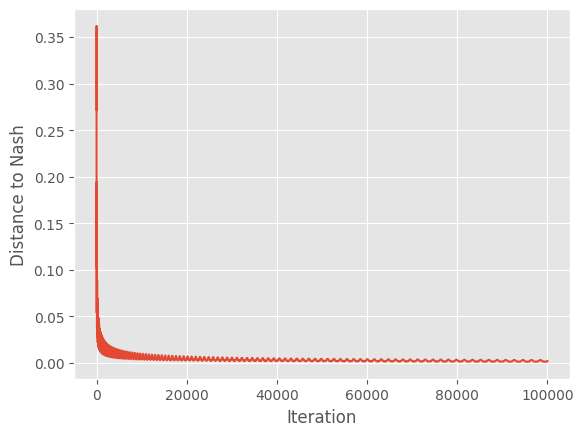

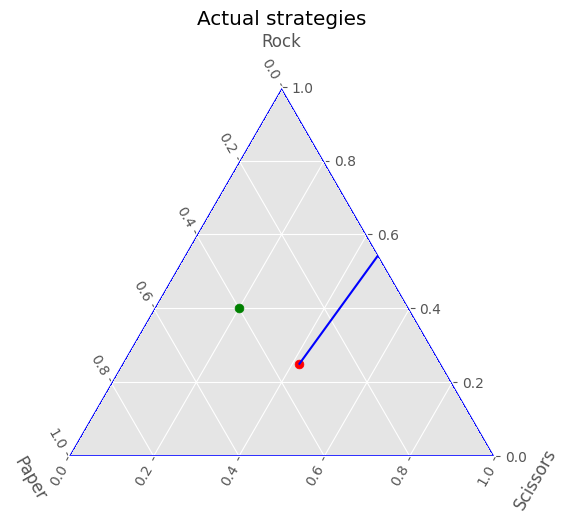

In [102]:


class RegretMatcher():
    def __init__(self, initial_guess):
        self.regret_tracker = initial_guess

    def regret_updates(self, prior_policy, reward_vector):
        """Update the prior weights using the multiplicative weights update algorithm"""
        self.regret_tracker += (reward_vector - reward_vector.T @ prior_policy)

    def compute_policy(self):
        """Compute the policy from the weights"""
        return np.maximum(0, self.regret_tracker) / np.sum(np.maximum(0, self.regret_tracker))

    def regret_policy_update(self, prior_policy, reward_vector):
        """Update the policy using the multiplicative weights update algorithm"""
        self.regret_updates(prior_policy, reward_vector)
        return self.compute_policy()
    
x_policy = RegretMatcher(np.array([0.3, 0.4, 0.5]))
y_policy = RegretMatcher(np.array([0.3, 0.4, 0.5]))
num_iters = 100000
x_policy_arr = np.zeros((num_iters + 1, 3))
y_policy_arr = np.zeros((num_iters + 1, 3))
x_policy_arr[0] = x_policy.compute_policy()
y_policy_arr[0] = y_policy.compute_policy()

for i in range(1, num_iters + 1):
    x_reward = compute_reward_vector(x_policy.compute_policy(), y_policy.compute_policy(), 0)
    y_reward = compute_reward_vector(x_policy.compute_policy(), y_policy.compute_policy(), 1)
    x_policy.regret_policy_update(x_policy.compute_policy(), x_reward)
    y_policy.regret_policy_update(y_policy.compute_policy(), y_reward)
    x_policy_arr[i] = x_policy.compute_policy()
    y_policy_arr[i] = y_policy.compute_policy()

plot_results(x_policy_arr, y_policy_arr, time_avg=True)


x_policy_arr[0]

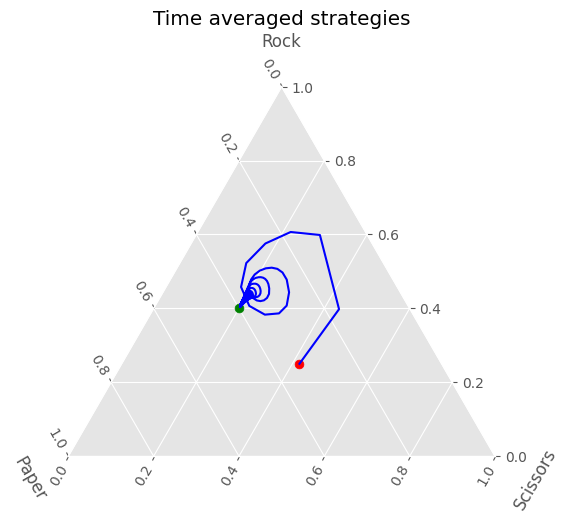

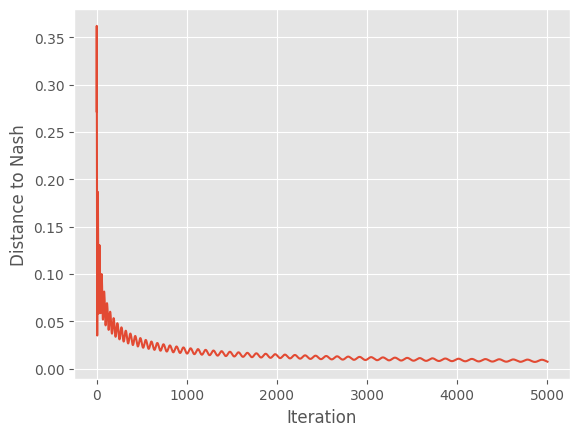

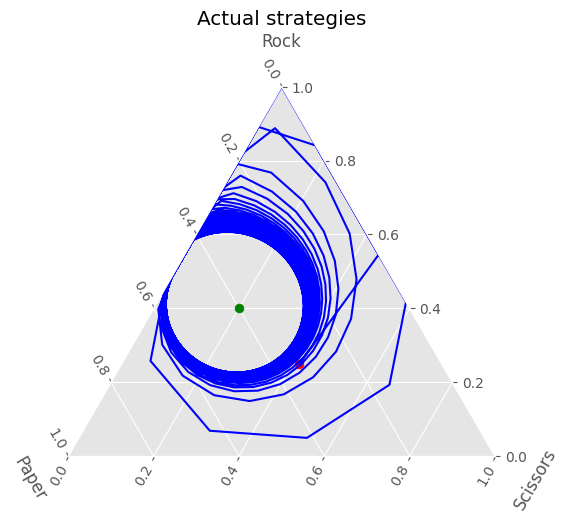

In [95]:


class RegretMatcherPlus():
    def __init__(self, initial_guess):
        self.regret_tracker = initial_guess

    def regret_updates(self, prior_policy, reward_vector):
        """Update the prior weights using the multiplicative weights update algorithm"""
        self.regret_tracker += (reward_vector - reward_vector.T @ prior_policy)
        self.regret_tracker = np.maximum(0, self.regret_tracker)

    def compute_policy(self):
        """Compute the policy from the weights"""
        return np.maximum(0, self.regret_tracker) / np.sum(np.maximum(0, self.regret_tracker))

    def regret_policy_update(self, prior_policy, reward_vector):
        """Update the policy using the multiplicative weights update algorithm"""
        self.regret_updates(prior_policy, reward_vector)
        return self.compute_policy()
    
x_policy = RegretMatcherPlus(np.array([0.3, 0.4, 0.5]))
y_policy = RegretMatcherPlus(np.array([0.3, 0.4, 0.5]))
num_iters = 5000
x_policy_arr = np.zeros((num_iters + 1, 3))
y_policy_arr = np.zeros((num_iters + 1, 3))
x_policy_arr[0] = x_policy.compute_policy()
y_policy_arr[0] = y_policy.compute_policy()

for i in range(1, num_iters + 1):
    x_reward = compute_reward_vector(x_policy.compute_policy(), y_policy.compute_policy(), 0)
    y_reward = compute_reward_vector(x_policy.compute_policy(), y_policy.compute_policy(), 1)
    x_policy.regret_policy_update(x_policy.compute_policy(), x_reward)
    y_policy.regret_policy_update(y_policy.compute_policy(), y_reward)
    x_policy_arr[i] = x_policy.compute_policy()
    y_policy_arr[i] = y_policy.compute_policy()

plot_results(x_policy_arr, y_policy_arr, time_avg=True)
